# Hands-On NLP

## Class 2

<span style="color:magenta">Group Names:</span>

* Name 1
* Name 2
* Name 3

### Outline

- Embeddings from scratch

- Classifications with embeddings

In [1]:
import re
import unicodedata
from collections import Counter
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

nltk.download("punkt")

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 2)

[nltk_data] Downloading package punkt to /Users/evrard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%config InlineBackend.figure_format="retina"  # For high DPI display

# %load_ext blackcellmagic

In [4]:
DATA = Path("../data")

TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

In [5]:
TEXT_P.mkdir(exist_ok=True)

# Getting the data

In [6]:
corpora = {}
stats = []

for corpus in tqdm(CORPORA):
    print(corpus)
    texts = []
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            texts.append(f.read())

    corpora[corpus] = "".join(texts)

    stats.append(
        {
            "corpus": corpus,
            "files_n": len(texts),
            "chars_n": len(corpora[corpus]),
        }
    )

df = pd.DataFrame.from_records(stats, index=["corpus"])
df["text"] = [corpora[corpus] for corpus in corpora]
df

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


,files_n,chars_n,text
corpus,,,
mythology,1428,4689305,Q:\n\nCan anyone identify what Chinese mytholo...
woodworking,2461,6729416,Q:\n\nGlue-up for butcher block-style countert...
robotics,2981,7254006,Q:\n\nHow is this torque value arrived?\n\nI'm...
hsm,2329,7364214,"Q:\n\nWhen and why did people stopped using ""n..."
health,3412,9148631,Q:\n\nHelp reading an eyeglass prescription: W...
portuguese,1840,4415251,"Q:\n\nQual a origem da expressão ""o fim da pic..."


### Tokenizing

In [7]:
# If your machine is slow, pickeling allows to go faster next time.

tokens_fp = DATA / "tokens.pkl"
try:
    tokens = pd.read_pickle(tokens_fp)
except FileNotFoundError:
    tokens = df.text.progress_map(word_tokenize)
    tokens.to_pickle(tokens_fp)

In [8]:
df["tokens"] = tokens
df["tokens_n"] = df.tokens.map(len)
df["types_n"] = df.tokens.map(set).map(len)
df

,files_n,chars_n,text,tokens,tokens_n,types_n
corpus,,,,,,
mythology,1428,4689305,Q:\n\nCan anyone identify what Chinese mytholo...,"[Q, :, Can, anyone, identify, what, Chinese, m...",942611,51243
woodworking,2461,6729416,Q:\n\nGlue-up for butcher block-style countert...,"[Q, :, Glue-up, for, butcher, block-style, cou...",1390534,32316
robotics,2981,7254006,Q:\n\nHow is this torque value arrived?\n\nI'm...,"[Q, :, How, is, this, torque, value, arrived, ...",1526918,53823
hsm,2329,7364214,"Q:\n\nWhen and why did people stopped using ""n...","[Q, :, When, and, why, did, people, stopped, u...",1445136,62465
health,3412,9148631,Q:\n\nHelp reading an eyeglass prescription: W...,"[Q, :, Help, reading, an, eyeglass, prescripti...",1714930,66007
portuguese,1840,4415251,"Q:\n\nQual a origem da expressão ""o fim da pic...","[Q, :, Qual, a, origem, da, expressão, ``, o, ...",907253,60276


# Vectorization

In [9]:
words = (
    "myth,wood,robot,history,science,mathematics,health,portuguese,o"
)

words.count("myth")

1

In [10]:
words = (
    "myth,wood,robot,history,science,mathematics,health,portuguese,o".split(",")
)
wc_df = pd.DataFrame(index=df.index)
for w in words:
    wc_df[w] = df.tokens.map(lambda x: x.count(w))

In [11]:
wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,769,55,6,179,21,4,18,0,27
woodworking,5,7535,0,18,9,0,48,0,2
robotics,0,21,4895,23,22,43,3,0,63
hsm,26,14,2,921,846,1578,28,1,25
health,46,10,1,207,114,6,1576,1,3
portuguese,2,11,3,13,3,1,8,41,14589


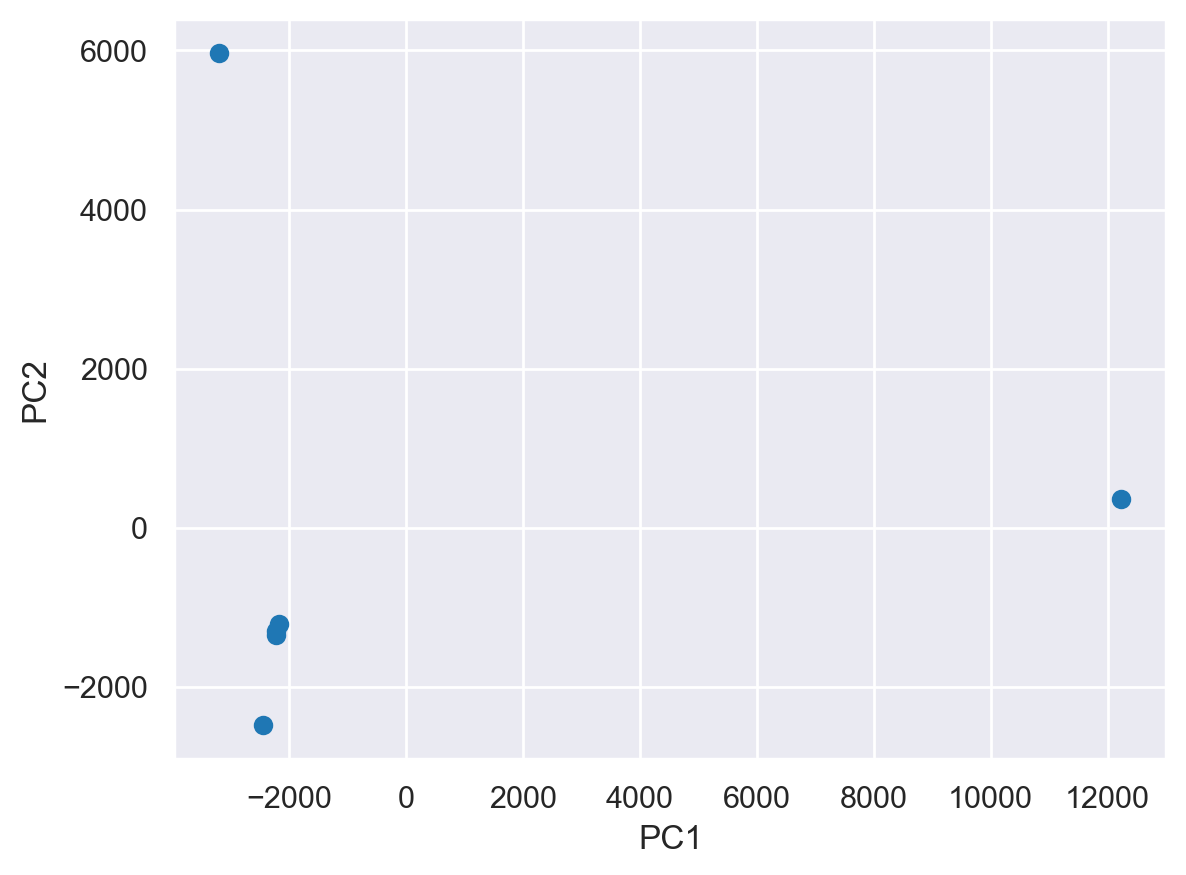

In [12]:
pca = decomposition.PCA(n_components=2)
text_pcs = pca.fit_transform(wc_df)

pc1, pc2 = text_pcs.T

plt.scatter(pc1, pc2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [13]:
text_pc_df = pd.DataFrame(text_pcs, columns=["PC1", "PC2"])
text_pc_df["label"] = wc_df.index
text_pc_df

,PC1,PC2,label
0,-2172.12,-1204.42,mythology
1,-3185.95,5969.32,woodworking
2,-2446.45,-2479.25,robotics
3,-2214.38,-1352.87,hsm
4,-2215.39,-1297.79,health
5,12234.29,365.01,portuguese


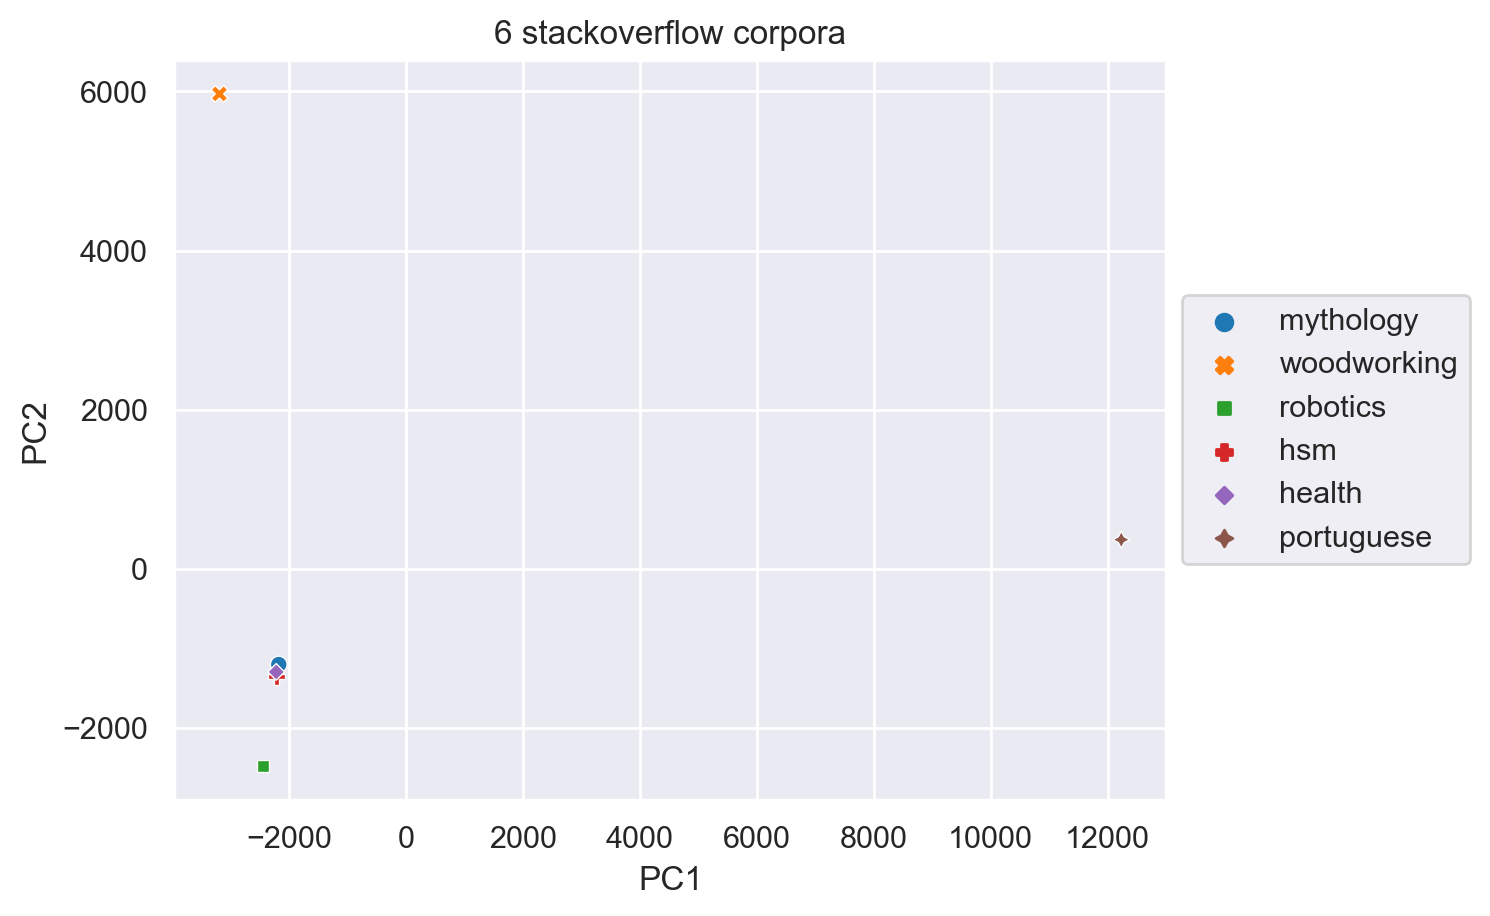

In [14]:
ax = sns.scatterplot(x="PC1", y="PC2", data=text_pc_df, hue="label", style="label")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("6 stackoverflow corpora")
plt.show()

### Bag of words

#### 🚧 TODO: Implement another bag of words vectorizer model on the corpus

*   This time using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

*   Try first the provided example in the `CountVectorizer` documentation

    *   Try with and without the n-gram parameter <br/><br/>

*   Then try to vectorize the stackoverflow corpus using `vocabulary=words`

Corrected example:

In [15]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())

print(xs.toarray())

vectorizer_2gram = CountVectorizer(analyzer="word", ngram_range=(2, 2))
x2s = vectorizer_2gram.fit_transform(corpus)

print(vectorizer_2gram.get_feature_names_out())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']


In [16]:
vocabulary = ["and", "document", "first"]
vectorizer = CountVectorizer(vocabulary=vocabulary)

xs = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(xs.toarray())

['and' 'document' 'first']
[[0 1 1]
 [0 2 0]
 [1 0 0]
 [0 1 1]]


In [17]:
cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())
cv_df.insert(0, "Document", corpus)
cv_df

,Document,and,document,first
0,This is the first document.,0,1,1
1,This document is the second document.,0,2,0
2,And this is the third one.,1,0,0
3,Is this the first document?,0,1,1


### Reprocess the stackoverflow corpora with `CountVectorizer`

In [18]:
vectorizer = CountVectorizer(vocabulary=words)
xs = vectorizer.fit_transform(df.text)

cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())
cv_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
0,867,75,6,307,35,4,23,4,0
1,5,8017,1,19,16,0,53,0,0
2,0,22,5321,25,33,50,3,2,0
3,28,17,2,1513,1174,2095,39,7,0
4,55,13,1,242,263,9,2178,4,0
5,2,13,3,18,7,3,9,1061,0


#### 🚧 TODO: Why is this different? 

- Try to explain

- Give some examples

In [19]:
test_text = (
    "myth wood robot history science mathematics health portuguese o "
    "myth wood robot history science mathematics health portuguese o"
)

freqs = [test_text.split().count(w) for w in words]

test_wc_df = pd.DataFrame([freqs], columns=words, index=["test_text"])
test_wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
test_text,2,2,2,2,2,2,2,2,2


In [20]:
test_xs = vectorizer.fit_transform([test_text])

test_cv_df = pd.DataFrame(
    test_xs.toarray(), 
    columns=vectorizer.get_feature_names_out(), 
    index=["test_text"]
)
test_cv_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
test_text,2,2,2,2,2,2,2,2,0


rtfm:

- `token_patternstr`, `default=r"(?u)\b\w\w+\b"`

    Regular expression denoting what constitutes a "token", only used if 
    `analyzer == "word"`. The default regexp select tokens of 2 
    or more alphanumeric characters 
    (punctuation is completely ignored and always treated as a token separator).
    
- Other reasons?

#### Is this difference important?

• Visualize the PCA

In [21]:
vectorizer = CountVectorizer(vocabulary=words)
xs = vectorizer.fit_transform(df.text)

pca = decomposition.PCA(n_components=2)

text_cv_df = pd.DataFrame(
    pca.fit_transform(xs.toarray()), columns=["PC1", "PC2"]
)
text_cv_df.insert(0, "Label", df.index)
text_cv_df

,Label,PC1,PC2
0,mythology,-1032.50,-988.52
1,woodworking,6729.60,532.64
2,robotics,-2169.28,4142.60
3,hsm,-1271.06,-1471.11
4,health,-1171.62,-1239.50
5,portuguese,-1085.14,-976.11


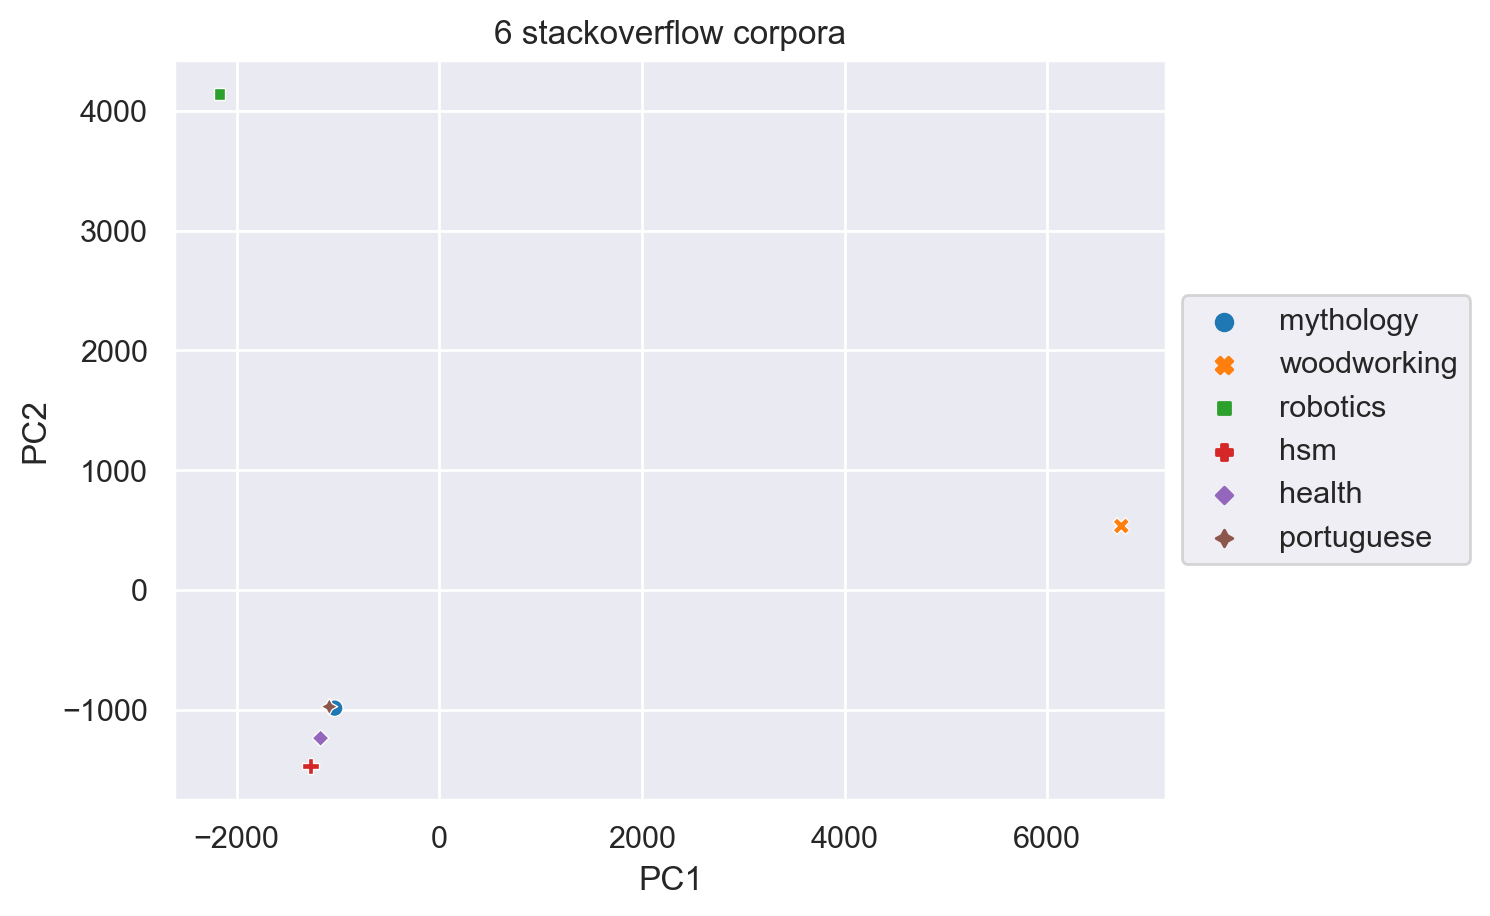

In [22]:
ax = sns.scatterplot(x="PC1", y="PC2", data=text_cv_df, hue="Label", style="Label")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("6 stackoverflow corpora")
plt.show()

-----------

## Hold the corpus as individual documents

In [23]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [24]:
doc_df = pd.DataFrame.from_records(data).set_index("id")
doc_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0
...,...,...,...
portuguese.stackexchange_0000001017,"Q:\n\n""pois não"" has an affirmative connotatio...",portuguese,5
portuguese.stackexchange_0000004609,"Q:\n\nPor que ""Teiú"" tem acento?\n\nMonossílab...",portuguese,5
portuguese.stackexchange_0000000484,"Q:\n\nRegional usage of ""guitarra"" and ""violão...",portuguese,5


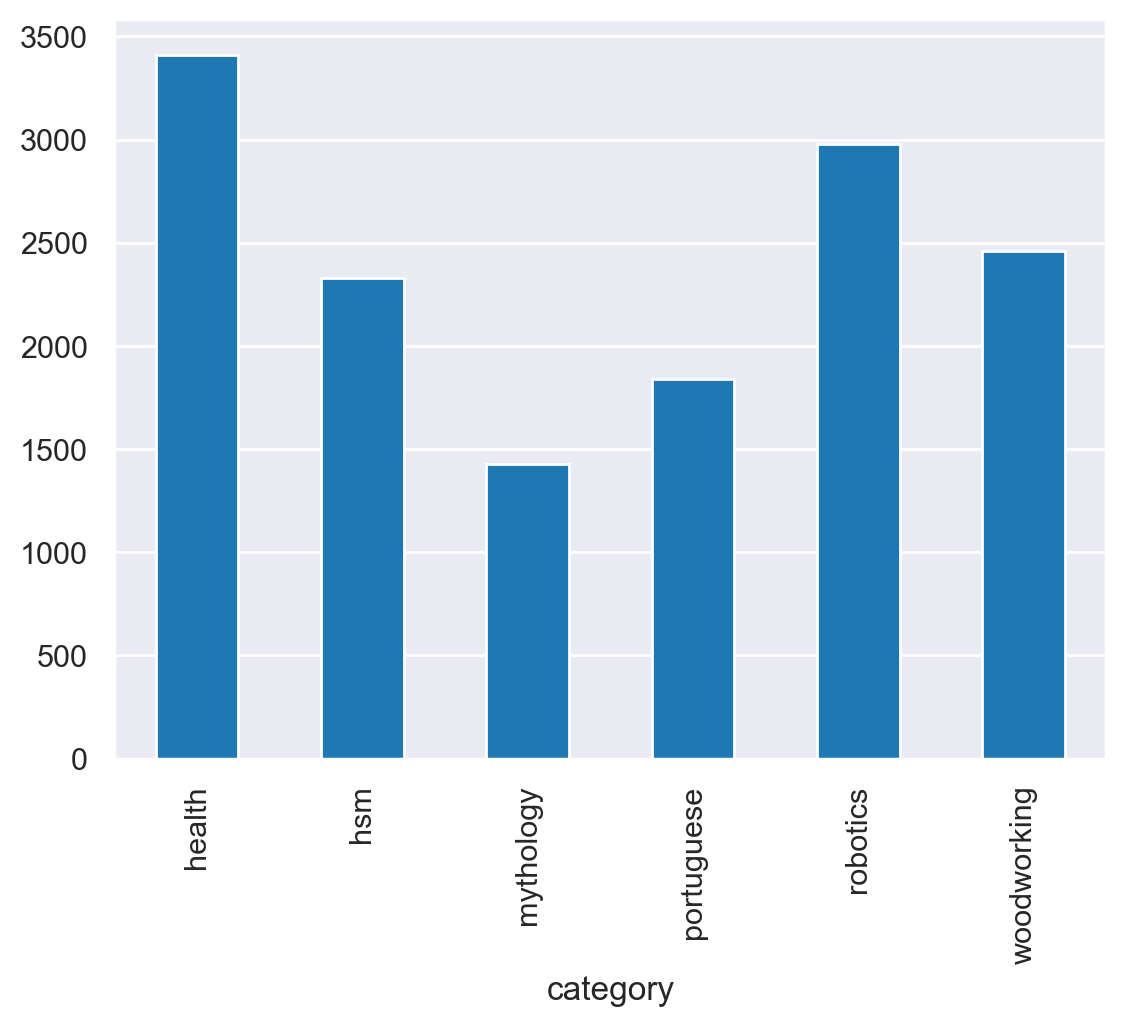

In [25]:
# doc_df.groupby("category").cat_id.value_counts().plot.bar()
doc_df.groupby("category").size().plot.bar()
plt.grid(axis="x")

In [26]:
# Careful: slow again!

doc_df["tokens_n"] = doc_df.text.progress_map(word_tokenize).map(len)
doc_df.head()

  0%|          | 0/14451 [00:00<?, ?it/s]

,text,category,cat_id,tokens_n
id,,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0,149
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0,479
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0,634
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0,761
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0,1213


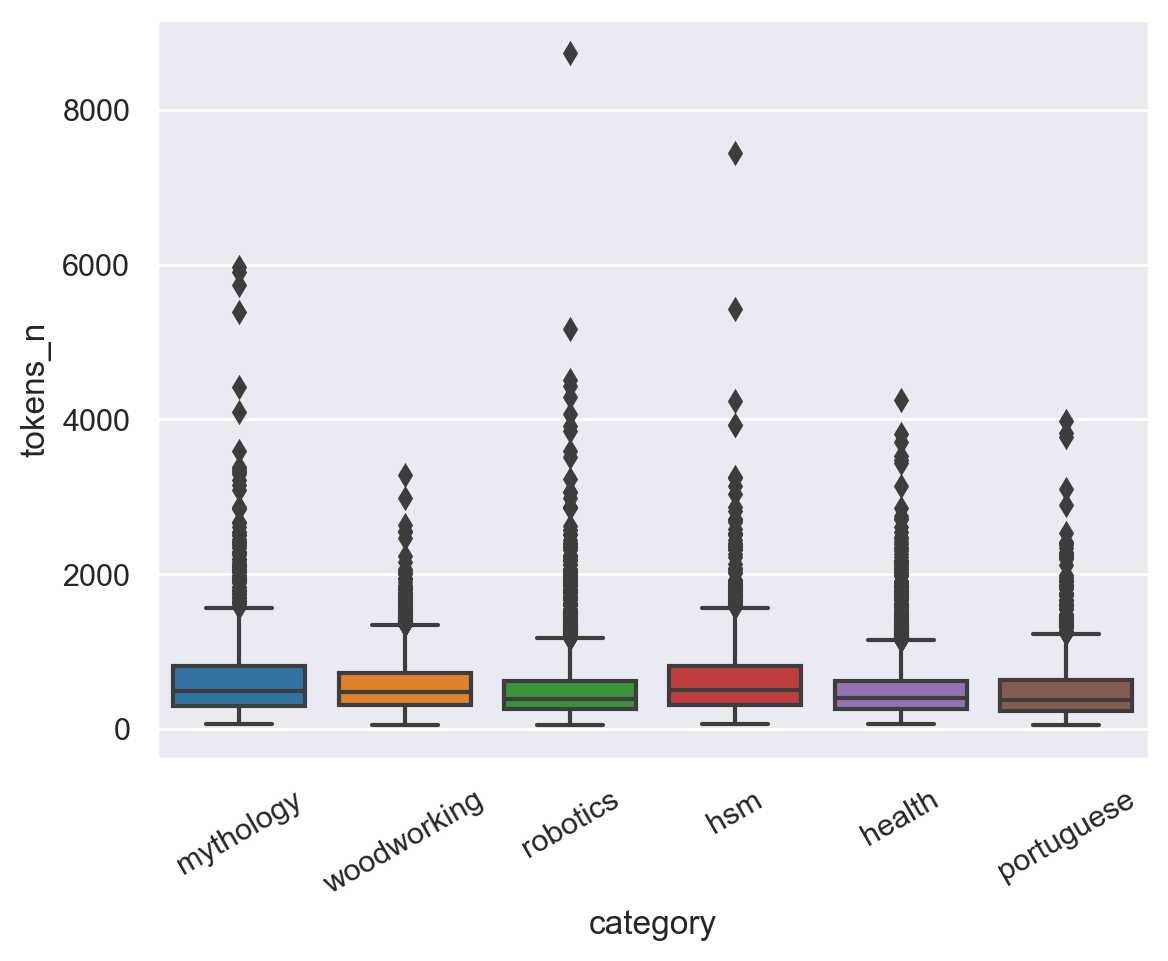

In [27]:
sns.boxplot(data=doc_df, x="category", y="tokens_n")
plt.xticks(rotation=30)
plt.show()

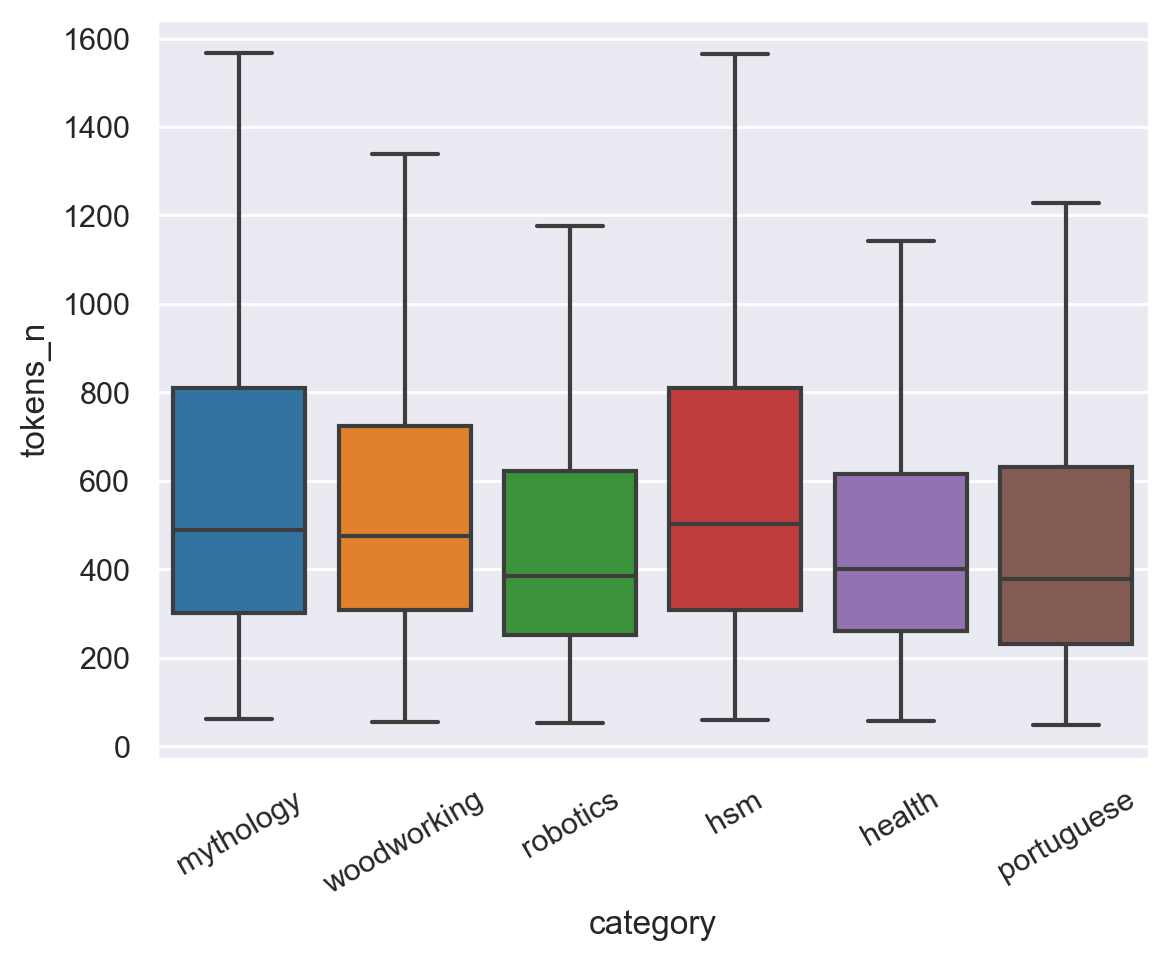

In [28]:
sns.boxplot(data=doc_df, x="category", y="tokens_n", showfliers=False)
plt.xticks(rotation=30)
plt.show()

#### Are the texts of signifcantly different length?

no:

*   *Notched box plots apply a "notch" or narrowing of the box around the median. Notches are useful in offering a rough guide of the significance of the difference of medians; if the notches of two boxes do not overlap, this will provide evidence of a statistically significant difference between the medians.*
    
    (McGill, Tukey, Larsen (1978). Variations of Box Plots. The American Statistician.)
  
#### 🚧 todo:

*   explain box-and-whisker plot
    
    https://en.wikipedia.org/wiki/Box_plot

### 🚧 TODO: How to find the crazy long robotics text?

*   Find the index of the longest text

*   Show the content

*   Explain why this text is so long (what does it contain?)

In [29]:
longests_df = doc_df[doc_df.tokens_n == doc_df.tokens_n.max()]
longests_df

,text,category,cat_id,tokens_n
id,,,,
robotics.stackexchange_0000022063,Q:\n\n6DOF Kinematics moveo\n\nI asked on stac...,robotics,2,8734


In [30]:
PTR = 5000

longests_df.text.values[0][PTR : PTR + 1000]

'141.0, 90.0, 180.0, -90.0};\n  float X14[6]={164.5+100.0, 0.0, 141.0, 90.0, 180.0, -90.0};\n  float X15[6]={164.5+85.3, -35.4, 141.0, 90.0, 180.0, -90.0};\n  float X16[6]={164.5+50.0, -50.0, 141.0, 90.0, 180.0, -90.0};\n  float X17[6]={164.5+14.7, -35.4, 141.0, 90.0, 180.0, -90.0};\n\n  float X18[6]={164.5+50.0, 0.0, 141.0, 90.0, 180.0, -90.0};\n  \n  float X2[6]={264.5, 0.0, 141.0, 0.0, 90.0, 0.0};\n  float X3[6]={164.5, 100.0, 141.0, 90.0, 90.0, 0.0};\n  float X4[6]={164.5, -100.0, 141.0, 90.0, -90.0, 0.0};\n  \n  float Jhome[6], J1[6], J11[6], J12[6], J13[6], J14[6], J15[6], J16[6], J17[6], J18[6], J2[6], J3[6], J4[6];\n  float Fhome[6];\n  InverseK(Xhome, Jhome);\n  ForwardK(Yhome, Fhome);\n  Serial.println("inverse:");\n  Serial.println(Jhome[0]);\n  Serial.println(Jhome[1]);\n  Serial.println(Jhome[2]);\n  Serial.println(Jhome[3]);\n  Serial.println(Jhome[4]);\n  Serial.println(Jhome[5]);\n  Serial.println("------");\n  Serial.println("forward:");\n  Serial.println(Fhome[0]);\n 

It's code!

### Vectorizing again

We want something like this:

```python
xs ~ doc_df.text
ys ~ doc_df.cat_id
```

In [31]:
ys = doc_df.cat_id.values

#### 🚧 TODO: See how many features we get if we don't restrict them

In [32]:
unconstrained_cv = CountVectorizer()
xs = unconstrained_cv.fit_transform(doc_df.text).toarray()
print("xs.shape :", xs.shape)
print("ys.shape :", ys.shape)

xs.shape : (14451, 153122)
ys.shape : (14451,)



**<span style="color:magenta">Response:</span>**

153122

In [33]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(doc_df.text).toarray()
print("xs.shape :", xs.shape)
print("ys.shape :", ys.shape)

xs.shape : (14451, 5000)
ys.shape : (14451,)


In [34]:
fts_df = pd.DataFrame(cv.get_feature_names_out(), columns=["word"])
fts_df

,word
0,00
1,000
2,01
3,02
4,03
...,...
4995,zinc
4996,às
4997,água
4998,ênfase


In [35]:
pca = decomposition.PCA(n_components=2)
doc_pcs = pca.fit_transform(xs)
pc1, pc2 = doc_pcs.T

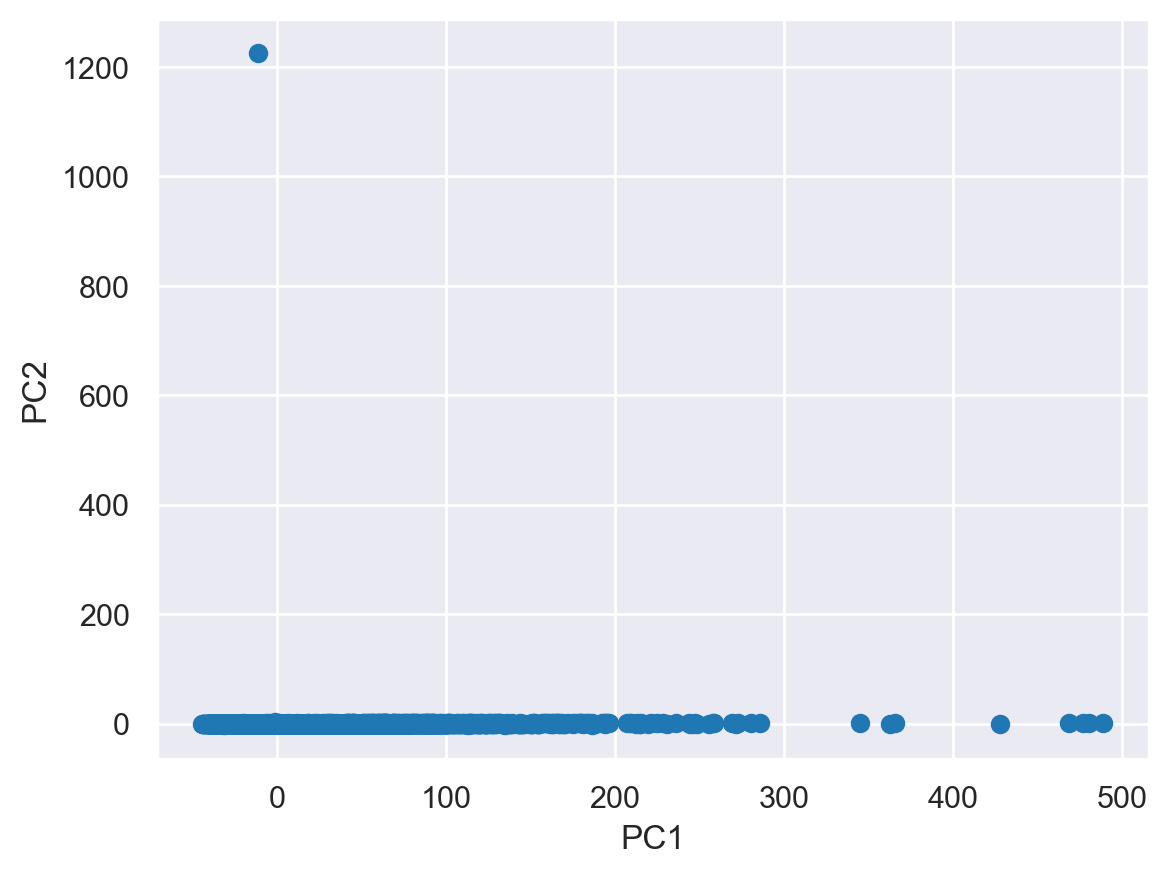

In [36]:
plt.scatter(pc1, pc2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#### 🚧 TODO: find that guy!

In [37]:
doc_df["PC1"], doc_df["PC2"] = doc_pcs.T
doc_df.head()

,text,category,cat_id,tokens_n,PC1,PC2
id,,,,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0,149,-27.00,-0.06
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0,479,-1.68,-0.14
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0,634,21.08,0.08
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0,761,20.00,-0.06
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0,1213,89.49,0.38


In [38]:
outlier_df = doc_df[doc_df.PC2 > 1000]
outlier_df

,text,category,cat_id,tokens_n,PC1,PC2
id,,,,,,
robotics.stackexchange_0000005103,Q:\n\narduino -lcd screen has weird noise with...,robotics,2,2570,-11.13,1225.72


In [39]:
print(outlier_df.text[0][:2222])

Q:

arduino -lcd screen has weird noise with multiple pictures

I'm connecting an arduino to a lcd screen using the following library. For the display code I have written a simple piece of code that should display 2 picture os eyes (1 angry one friendly) and switching at regular intervals, however the display keeps showing me weird pixels around the borders that shouldn't be there, by making it show the same eyes twice this can be fixed however as long as I have both eyes being used it runs into trouble. Here is my code: 
    void setup()
    {
      LCDA.initDriverPin(2,7,10); 
      LCDA.Initialise(); // INIT SCREEN  
      delay(100);
    }
    void loop(){
      LCDA.CLEAR(); //empty screen 
      delay(100);//wait for command to finish 

      LCDA.DrawFullScreen(eyes);
      delay(5000); //wait 5 seconds with eyes on the screen 

      LCDA.CLEAR();//clear screen
      delay(100);//wait for command to finish 
      LCDA.DrawFullScreen(angry); //show me the angry face 
      delay

#### 🚧 TODO: The reason for this outlier is...

**<span style="color:magenta">Response:</span>**

It contains a bitmap in 4bit encoding!

- Remove the row

- Redo the pca

In [40]:
print(doc_df.shape)
# 🚧 TODO: ... drop

doc_df.drop(outlier_df.index, inplace=True)

print(doc_df.shape)

(14451, 6)
(14450, 6)


In [41]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(doc_df.text).toarray()
ys = doc_df.cat_id.values

print("xs.shape :", xs.shape)
print("ys.shape :", ys.shape)

xs.shape : (14450, 5000)
ys.shape : (14450,)


In [42]:
pca = decomposition.PCA(n_components=2)
doc_pcs = pca.fit_transform(xs)
pc1, pc2 = doc_pcs.T

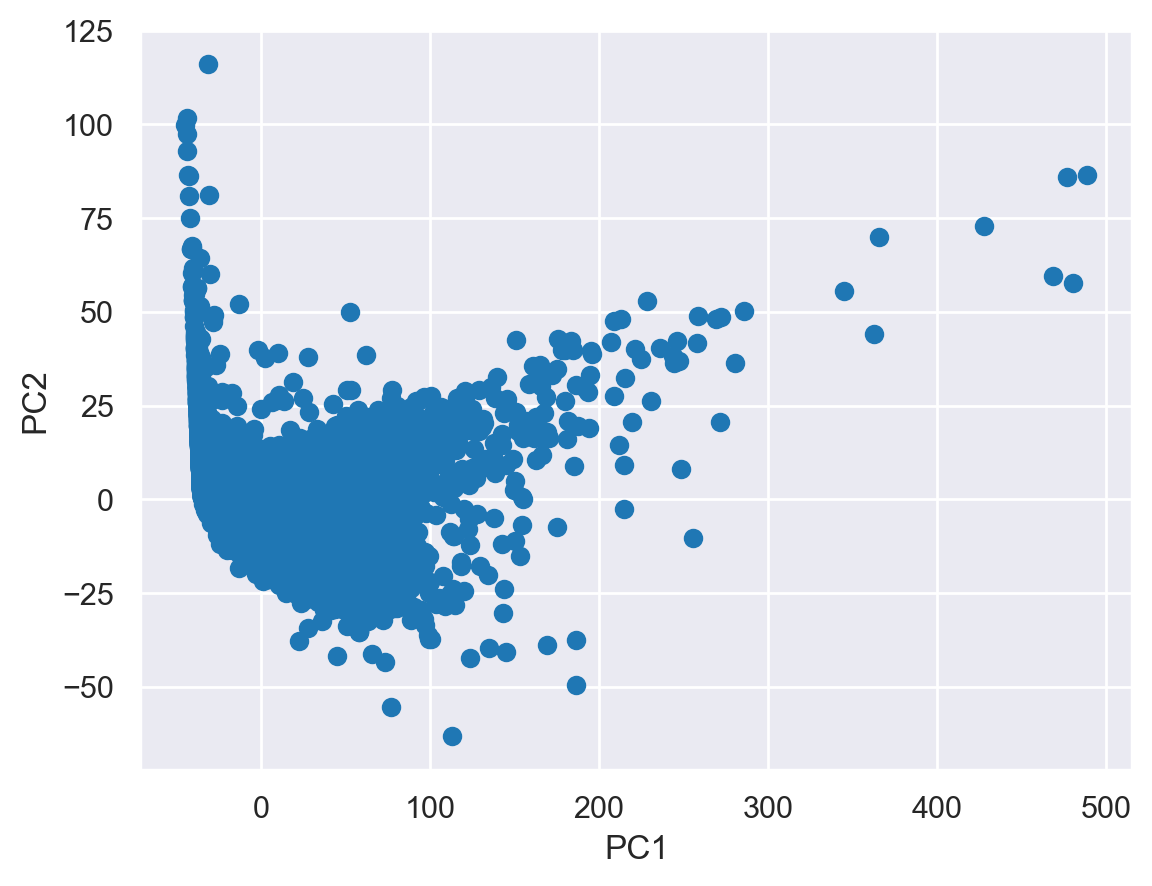

In [43]:
plt.scatter(pc1, pc2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [44]:
doc_df["PC1"], doc_df["PC2"] = doc_pcs.T
doc_df.head()

,text,category,cat_id,tokens_n,PC1,PC2
id,,,,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0,149,-27.00,-2.42
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0,479,-1.68,-2.19
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0,634,21.08,5.66
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0,761,20.00,0.93
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0,1213,89.49,19.28


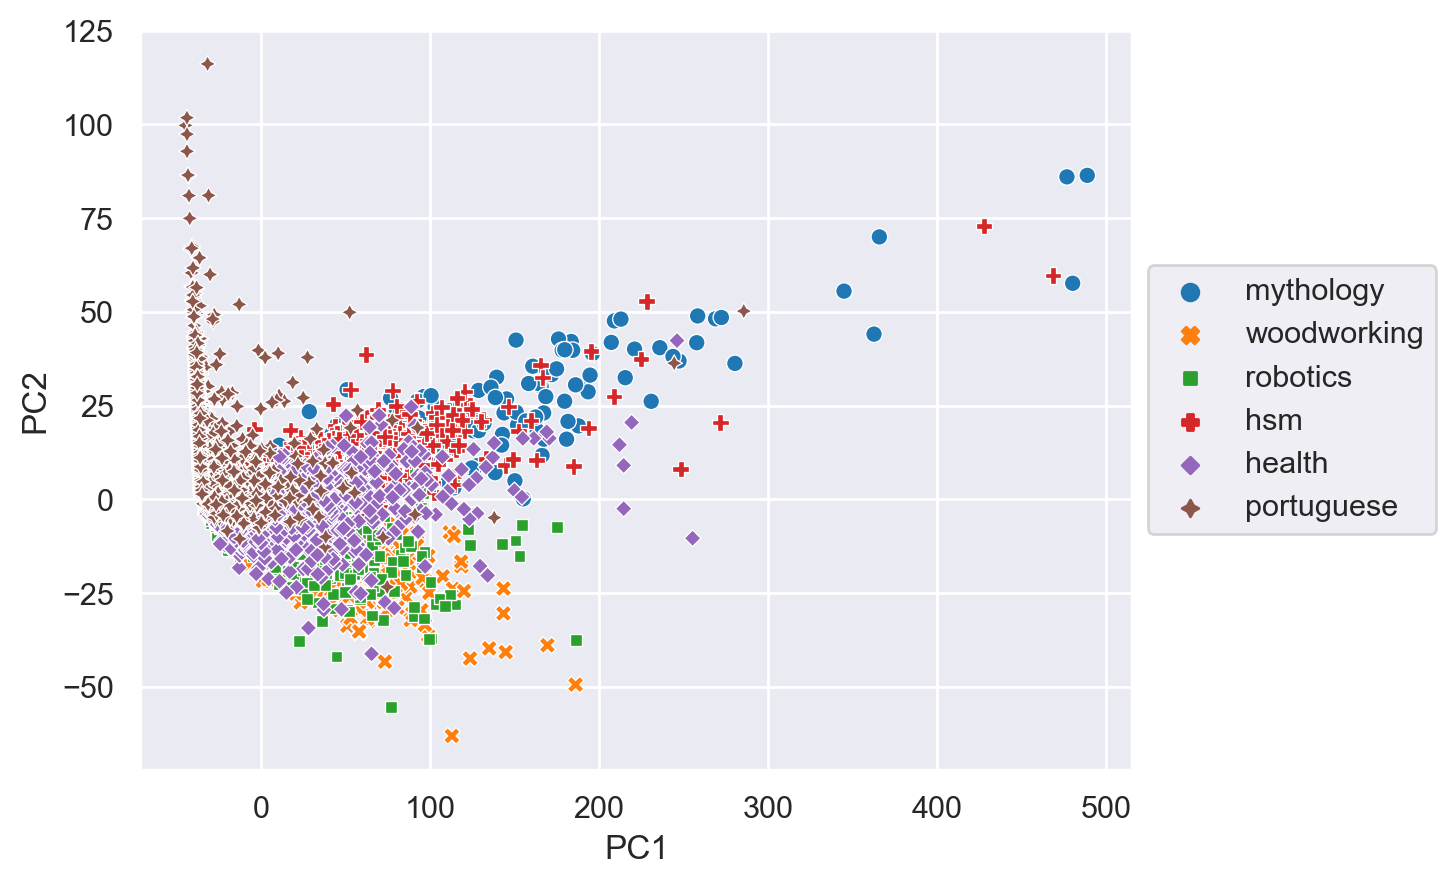

In [45]:
ax = sns.scatterplot(
    x="PC1", y="PC2", data=doc_df, hue="category", style="category"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## Learning to distinguish text subjects

### Train and test sets

In [46]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4335, 5000)


In [47]:
def run_model(model_name, train_xs, train_ys, test_xs, test_ys):
    model = ""

    if model_name == "LogRegression":
        model = LogisticRegression(max_iter=3000)
    elif model_name == "RandomForest":
        model = RandomForestClassifier(
            n_estimators=100, criterion="entropy", random_state=0
        )
    elif model_name == "MultinomialNB":
        model = MultinomialNB(alpha=1.0, fit_prior=True)
    elif model_name == "SVM":
        model = SVC()
    elif model_name == "DecisionTree":
        model = DecisionTreeClassifier()
    elif model_name == "KNN":
        model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    elif model_name == "GaussianNB":
        model = GaussianNB()

    oneVsRest = OneVsRestClassifier(model)
    oneVsRest.fit(train_xs, train_ys)
    pred_ys = oneVsRest.predict(test_xs)

    # Performance metrics
    accuracy = accuracy_score(test_ys, pred_ys)

    # Get precision, recall, f1 scores
    precision, recall, f1score, _ = score(test_ys, pred_ys, average="weighted")

    info = {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1score,
    }

    info_df = pd.DataFrame([info]).set_index("Model")
    display(info_df.style.format("{:,.2%}"))

    return info

#### 🚧 TODO:

* Careful: some may be long!

In [48]:
performance_infos = []

In [49]:
%%timeit -n 1 -r 1

performance_infos.append(
    run_model("MultinomialNB", train_xs, train_ys, test_xs, test_ys)
)

,Accuracy,Precision,Recall,F1-score
Model,,,,
MultinomialNB,96.49%,96.64%,96.49%,96.49%


6.21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [50]:
# %%timeit -n 1 -r 1

# performance_infos.append(
#     run_model("RandomForest", train_xs, train_ys, test_xs, test_ys)
# )

In [51]:
%%timeit -n 1 -r 1

performance_infos.append(
    run_model("LogRegression", train_xs, train_ys, test_xs, test_ys)
)

,Accuracy,Precision,Recall,F1-score
Model,,,,
LogRegression,98.29%,98.30%,98.29%,98.29%


1min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [52]:
# # You may want to skip this, too long!

# %%timeit -n 1 -r 1

# performance_infos.append(
#     run_model("DecisionTree", train_xs, train_ys, test_xs, test_ys)
# )

In [53]:
# # You may want to skip this, too long!
# # Compared to the 'todo'-version we've changed
# # the parameters in order to use all of your processors in parallel

# %%timeit -n 1 -r 1

# performance_infos.append(
#     run_model("KNN", train_xs, train_ys, test_xs, test_ys)
# )

In [54]:
%%timeit -n 1 -r 1

performance_infos.append(
    run_model("GaussianNB", train_xs, train_ys, test_xs, test_ys)
)

,Accuracy,Precision,Recall,F1-score
Model,,,,
GaussianNB,89.92%,90.94%,89.92%,90.00%


9.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### 🚧 TODO:

- Make a table of the performance

In [55]:
perf_df = pd.DataFrame(performance_infos).set_index("Model")
perf_df.sort_values("Accuracy", ascending=False, inplace=True)
# perf_df = perf_df.style.format({col: "{:,.2%}" for col in perf_df.columns[1:]})

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(perf_df.style.format("{:,.2%}"))

,Accuracy,Precision,Recall,F1-score
Model,,,,
LogRegression,98.29%,98.30%,98.29%,98.29%
MultinomialNB,96.49%,96.64%,96.49%,96.49%
GaussianNB,89.92%,90.94%,89.92%,90.00%


### 🚧 TODO:

- Explain what works best

**<span style="color:magenta">Response:</span>**

- The best accuracy is obtained for the random forest and the logistic regression. Multinomial Naive Bayes is close third and by far the fastest of the well-performing classifiers.

- Tweak one of the models that you know to improve the system

- Make a systematic change to the vectorization parameters and check the result in the performance of your favorite model

____